<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

/Users/janrange/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import optax
import jax.random as jrandom
import jax.numpy as jnp
import numpy as np

from catalax import Model, visualize
from catalax.neural import NeuralODE, Strategy, train_neural_ode

In [3]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[K_m, v_max]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


In [4]:
# Generate irregular time series data
# from a simple menten model

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
time = jnp.array([
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
])

# Set initial conditions above and below the 
# true Km value for the sake of the example
initial_conditions = [
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
data = np.random.normal(data, 1.0).clip(min=0)

# Turn intiial conditions into a matrix (Not yet part of the NeuralODE workflow)
y0s = model._assemble_y0_array(initial_conditions, in_axes=(0, None, None))

print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")

Time: (4, 6) | Data: (4, 6, 1) | Initial Conditions: (4, 1)


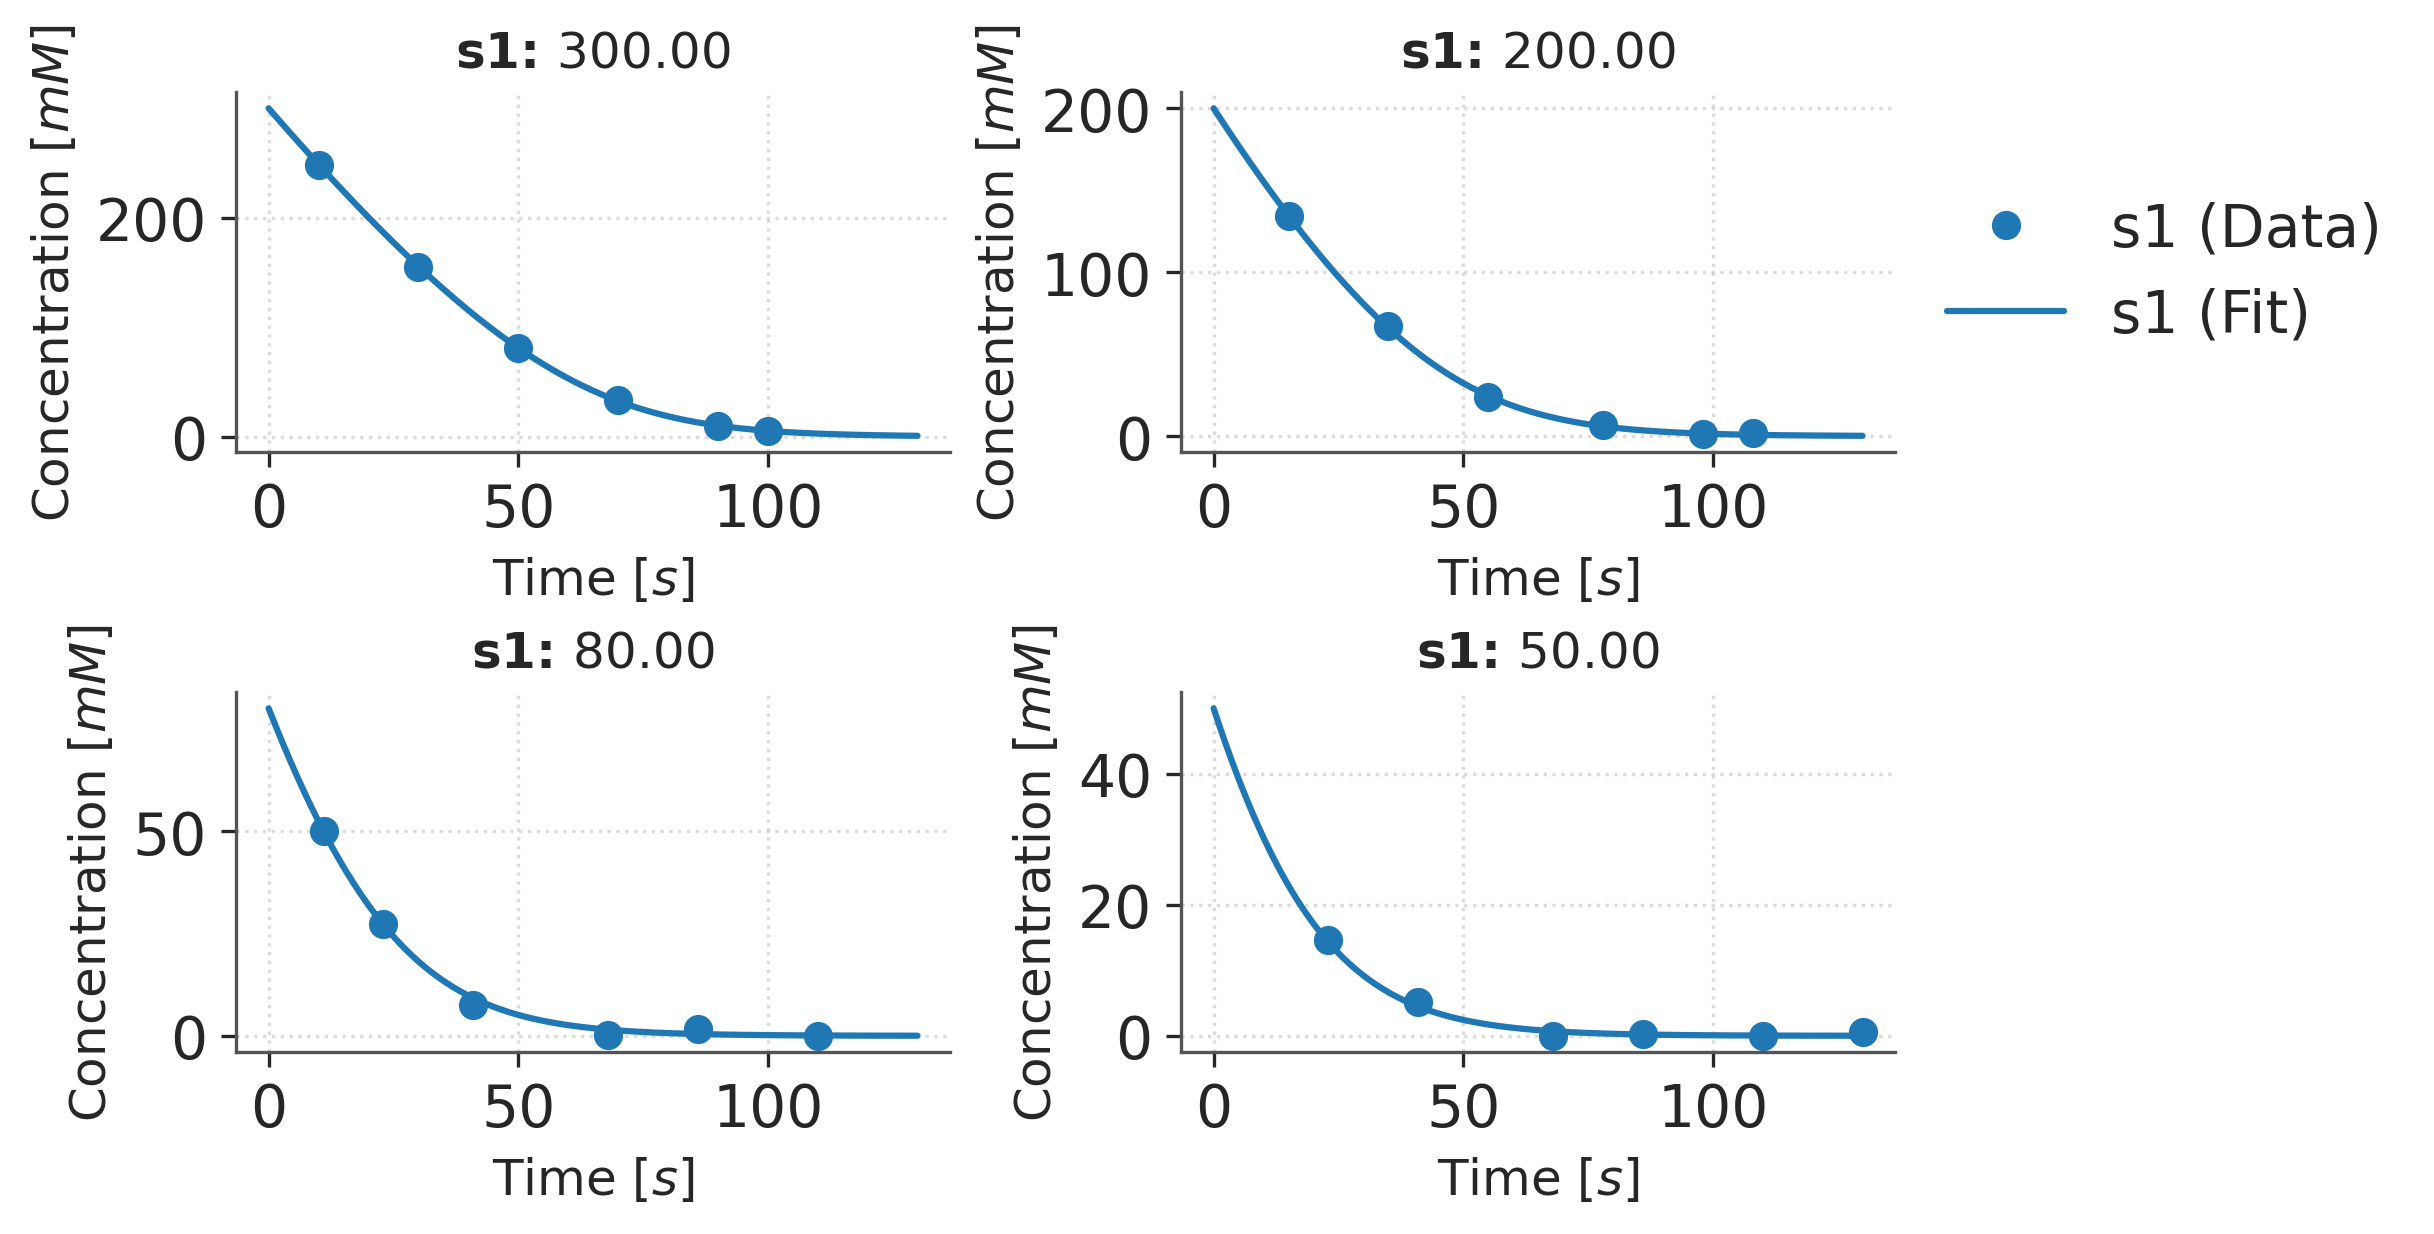

In [5]:
f = visualize(
    model=model,
    data=data,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(4,2),
)

In [6]:
# Handle PRNG keys
key = jrandom.PRNGKey(420)
data_key, model_key, loader_key = jrandom.split(key, 3)

# Create a neural ODE model
neural_ode = NeuralODE.from_model(model, width_size=12, depth=2, key=model_key)

# Set up a training strategy (You can interchange the optimizer and loss function too!)
strategy = Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=10000, batch_size=3)
strategy.add_step(lr=1e-4, steps=20000, loss=optax.huber_loss, batch_size=3)

# Train neural ODE
trained = train_neural_ode(
    model=neural_ode,
    data=data,
    times=time,
    inital_conditions=y0s,
    strategy=strategy,
    save_milestones=False, # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)


<< Strategy #1: Learning rate: 0.001 | Steps: 10000 Length: 10.0% >>



Loss: 0.3376 MAE: 0.5284: : 10100it [00:23, 437.61it/s]                          




<< Strategy #2: Learning rate: 0.0001 | Steps: 20000 Length: 100.0% >>



Loss: 0.1648 MAE: 0.4502: : 20100it [00:41, 482.61it/s]                         

/var/folders/d1/2jlg1jdd631b62bnxn30kmb40000gn/T/ipykernel_12507/4168641682.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


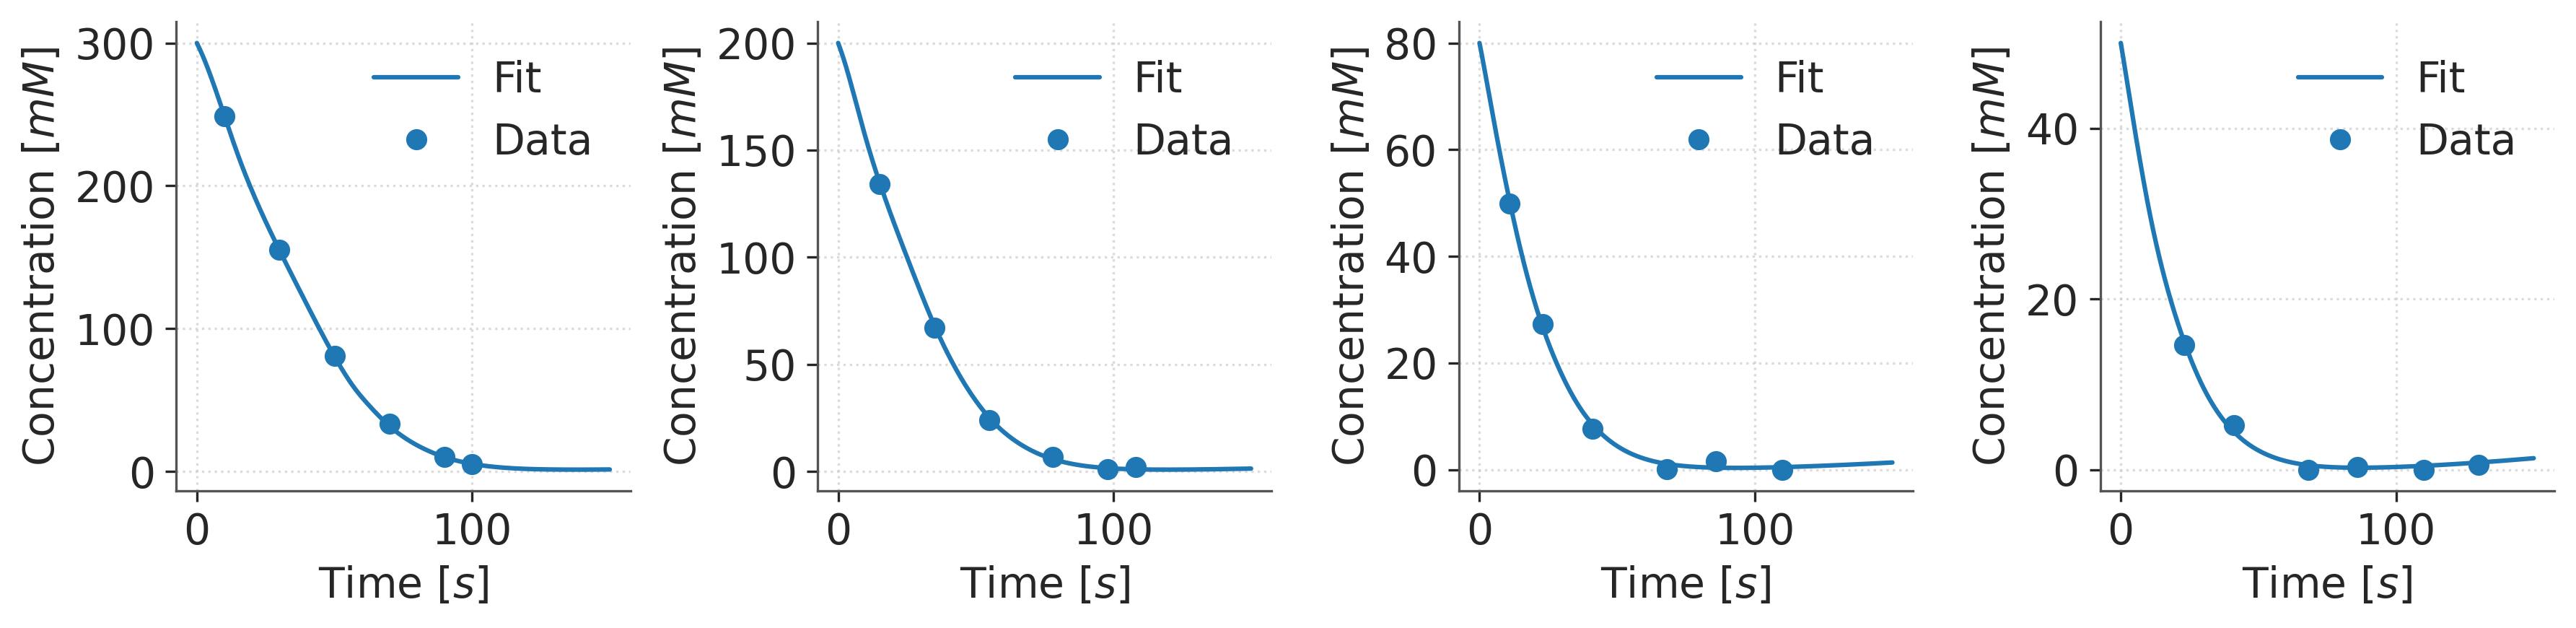

In [8]:
# Predict the trajectory of the learnt model
time_, states = trained.predict(y0s=y0s, t1=150)

# Note: The neural ODE visualizer is not yet implemented.
# Thus, this is done manual here.

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

species = model._get_species_order()
color = list(mcolors.TABLEAU_COLORS)[0]
f, ax = plt.subplots(1, y0s.shape[0], figsize=(12, 3))

for batch in range(states.shape[0]):
    ax[batch].plot(
        time_[batch],
        states[batch, :, species.index("s1")],
        label="Fit",
        c=color,
    )

    ax[batch].plot(
        time[batch],
        data[batch, :, species.index("s1")],
        "o",
        label="Data",
        c=color,
    )

    ax[batch].legend()
    ax[batch].grid(alpha=0.7, linestyle=":")
    ax[batch].set_xlabel("Time [$s$]")
    ax[batch].set_ylabel("Concentration [$mM$]")
    
plt.tight_layout()